## PaleoSTeHM: A modern, scalable Spatio-Temporal Hierarchical Modeling framework for paleo-environmental data

Yucheng Lin - yc.lin@rutgers.edu

with Alex Reedy and Robert Kopp

### Application 1: Kopp et al., 2016 Temperature-driven global sea-level variability in the Common Era

In this notebook, we will try to replicate global sea-level change signal in Common Era.

In [2]:
#load modules
import matplotlib.pyplot as plt
import matplotlib
import torch
import numpy as np
import pandas as pd
import pyro
import pyro.contrib.gp as gp
import pyro.distributions as dist
import cartopy
import cartopy.crs as ccrs
import matplotlib.path as mpath
import matplotlib.gridspec as gridspec
import cartopy.feature as cfeature
import sys
import nmmn.plots
import seaborn as sns
import os
import zipfile

sys.path.append('../../Code')
import PSTHM 
import time
parula=nmmn.plots.parulacmap() # for MATLAB's cmap

smoke_test = "CI" in os.environ  # ignore; used to check code integrity in the Pyro repo
assert pyro.__version__.startswith('1.8.4')

#set plotting style
%matplotlib inline
font = {'weight':'normal',
       'size':20}

matplotlib.rc('font',**font)
matplotlib.rcParams['figure.figsize'] = (12, 6)
import warnings
warnings.filterwarnings("ignore")

#### 1. Load and preprocess all sea-level data 

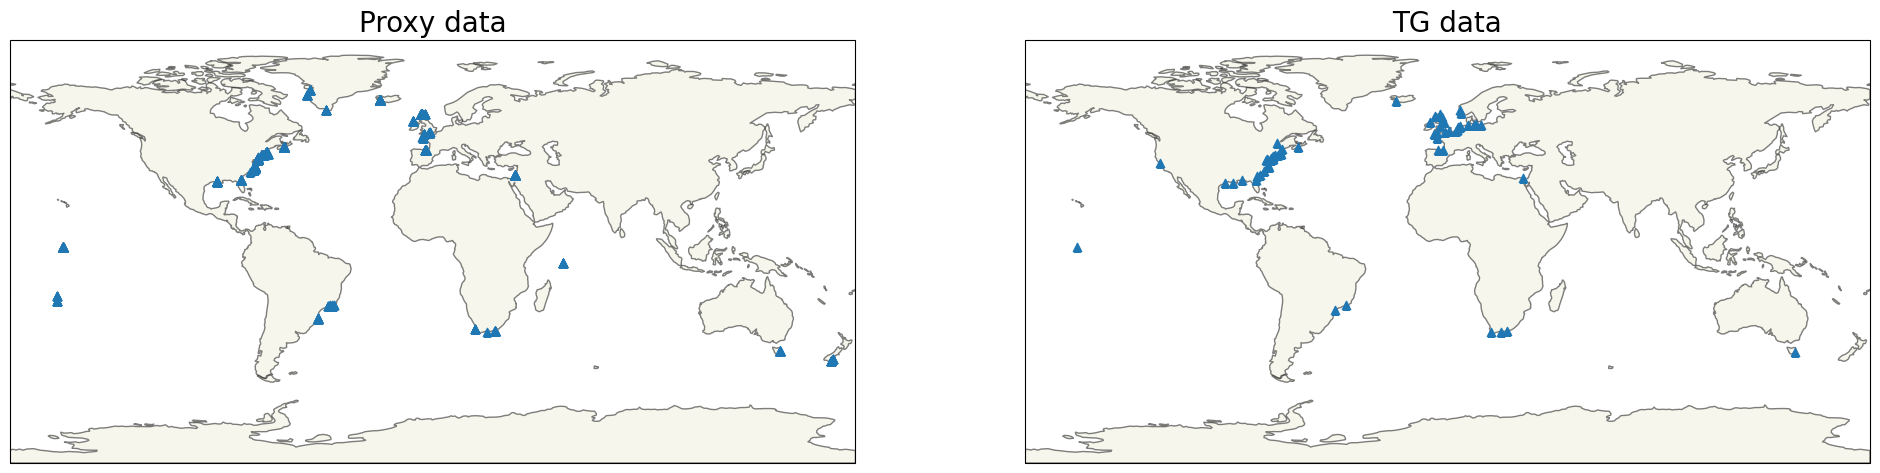

In [3]:
#load the proxy data
proxy_data = pd.read_csv('IFILES/RSL_All_30Dec2015.csv')
trainfirsttime = -1000
proxy_data = proxy_data[proxy_data['Age (CE)']>trainfirsttime]

TG_ID = pd.read_excel('IFILES/TG_ID.xlsx',skiprows=np.arange(1,4))

TG_data_folder = '../../Data/TG_data/'

if len(os.listdir(TG_data_folder))<5:
    with zipfile.ZipFile(TG_data_folder+'TG_data.zip', 'r') as zip_ref:
        zip_ref.extractall(TG_data_folder)
site_file = pd.read_table(TG_data_folder+'/filelist.txt',delimiter=';',header=None)
selection_index = np.array([i in list(TG_ID['PSMSL ID']) for i in site_file.iloc[:,0]])
selected_sites = site_file.iloc[selection_index,:]

plt.figure(figsize=(24,10))
ax2 = plt.subplot(121,projection=ccrs.PlateCarree())
ax2.set_global()
ax2.add_feature(cartopy.feature.LAND,edgecolor='black',zorder=0,alpha=0.5)
ax2.scatter(proxy_data['Longitude (E)'],proxy_data['Latitude (N)'],transform=ccrs.PlateCarree(),zorder=1,
            marker='^')
ax2.set_title('Proxy data',fontsize=20)

ax1 = plt.subplot(122,projection=ccrs.PlateCarree())
ax1.set_global()
ax1.add_feature(cartopy.feature.LAND,edgecolor='black',zorder=0,alpha=0.5)
ax1.scatter(selected_sites.iloc[:,2],selected_sites.iloc[:,1],transform=ccrs.PlateCarree(),zorder=1,
            marker='^')
ax1.set_title('TG data',fontsize=20);

**Load results from Hay et al., 2015**

In [4]:
import scipy.io as sio
gslfile = os.path.join('IFILES', 'Hay2015_KFandGP_GMSL.mat')

Haydat = sio.loadmat(gslfile)
Hay = {}

Hay['Y'] = Haydat['KF_GMSL'][0]
Hay['dY'] = np.sqrt(np.diag(Haydat['KF_GMSL_var']))
Hay['Ycv'] = Haydat['KF_GMSL_var']
Hay['datid'] = np.zeros_like(Hay['Y'])
Hay['time1'] = Haydat['tt_KF'][:]
Hay['time2'] = Hay['time1']
Hay['meantime'] = Hay['time1']
Hay['lat'] = np.ones_like(Hay['Y']) * 1e6
Hay['long'] = Hay['lat']
Hay['compactcorr'] = np.zeros_like(Hay['Y'])
Hay['limiting'] = np.zeros_like(Hay['Y'])
Hay['istg'] = np.ones_like(Hay['Y'])
Hay['siteid'] = 0
Hay['sitenames'] = ['Hay_KF_GMSL']
Hay['sitecoords'] = [1e6, 1e6]
Hay['sitelen'] = len(Hay['Y'])

# Smooth Hay et al curve
Hayavgwin = 10
Haystep = 10
HayGSL = Hay.copy()
HayGSL['time1'] = np.arange(1885, 2006, Haystep)
HayGSL['time2'] = HayGSL['time1']
HayGSL['meantime'] = HayGSL['time1']
M = np.abs(np.subtract.outer(HayGSL['time1'], Hay['time1'])) <= (Hayavgwin / 2)
M = M[:,0,:]
M = M / np.sum(M, axis=1, keepdims=True)
HayGSL['Y'] = M @ Hay['Y']
HayGSL['Ycv'] = M @ Hay['Ycv'] @ M.T
HayGSL['dY'] = np.sqrt(np.diag(HayGSL['Ycv']))
HayGSL['datid'] = np.zeros_like(HayGSL['Y'])
HayGSL['lat'] = np.ones_like(HayGSL['Y']) * 1e6
HayGSL['long'] = HayGSL['lat']
HayGSL['compactcorr'] = np.zeros_like(HayGSL['Y'])
HayGSL['limiting'] = np.zeros_like(HayGSL['Y'])
HayGSL['istg'] = np.ones_like(HayGSL['Y'])


**Pseudo data so that average rate of change between -100 to 100 CE and 1600-1800 CE is close to zero**

In [5]:
GSLflattener = {}
GSLflattener['sigma'] = 1e4
GSLflattener['time1'] = 0.01 + np.concatenate((np.arange(-100, 101, 50), np.arange(1600, 1801, 50)))
GSLflattener['Y'] = np.zeros_like(GSLflattener['time1'])
GSLflattener['Ycv'] = np.ones((len(GSLflattener['Y']), len(GSLflattener['Y']))) * (GSLflattener['sigma']**2)

GSLflattener['Ycv'][:5, :5] += ((0.0025 * 1700)**2 + np.eye(5) * GSLflattener['sigma']**2 - GSLflattener['sigma']**2 / 5)
GSLflattener['Ycv'][5:10, 5:10] += (np.eye(5) * GSLflattener['sigma']**2 - GSLflattener['sigma']**2 / 5)

GSLflattener['dY'] = np.sqrt(np.diag(GSLflattener['Ycv']))
GSLflattener['datid'] = np.zeros_like(GSLflattener['Y'])
GSLflattener['time2'] = GSLflattener['time1']
GSLflattener['meantime'] = GSLflattener['time1']
GSLflattener['lat'] = np.ones_like(GSLflattener['Y']) * 1e6
GSLflattener['long'] = GSLflattener['lat']
GSLflattener['compactcorr'] = np.zeros_like(GSLflattener['Y'])
GSLflattener['limiting'] = np.zeros_like(GSLflattener['Y'])
GSLflattener['istg'] = np.ones_like(GSLflattener['Y'])
GSLflattener['siteid'] = 0
GSLflattener['sitenames'] = ['GSLflattener']
GSLflattener['sitecoords'] = [1e6, 1e6]
GSLflattener['sitelen'] = len(GSLflattener['Y'])


**Load three old TG data**

In [6]:
import os
from scipy.sparse import dia_matrix

# old tide gauges

TGold = {
    'datid': [],
    'meantime': [],
    'Y': [],
    'dY': [],
    'lat': [],
    'long': [],
    'siteid': [],
    'sitenames': [],
    'sitecoords': [],
    'sitelen': [],
    'time1': [],
    'time2': [],
    'limiting': [],
    'compactcorr': [],
    'istg': [],
    'Ycv': None
}

for ppp in range(1, 4):
    if ppp == 1:
        dat = pd.read_csv(os.path.join('IFILES', 'amsterdam.sea.level.txt'), delim_whitespace=True,header=None)
        wsite = 'AMSTERDAM_OLD'
        wcurid = 5001
        wlat = [52.3667]
        wlong = [4.9000]
        wdatid = np.ones(len(dat)) * wcurid
        wtime = dat.iloc[:, 0].values
        wY = dat.iloc[:, 1].values
    elif ppp == 2:
        dat = pd.read_csv(os.path.join('IFILES', 'Kronstadt_ReportsFGI_Bogdanov_appendix.csv'))
        wsite = 'KRONSTADT_OLD'
        wcurid = 5002
        wlat = [59.98]
        wlong = [29.77]
        wdatid = np.ones(len(dat)) * wcurid
        wtime = dat.iloc[:, 0].values
        wY = dat.iloc[:, 2].values
    elif ppp == 3:
        dat = pd.read_csv(os.path.join('IFILES', 'ekman_2003_stockholm.csv'),skiprows=1)
        wsite = 'STOCKHOLM_OLD'
        wcurid = 5003
        wlat = [59.32]
        wlong = [18.08]
        wdatid = np.ones(len(dat)) * wcurid
        wtime = dat.iloc[:, 0].values
        wY = dat.iloc[:, 2].values

    TGold['datid'].extend(wdatid)
    TGold['meantime'].extend(wtime)
    TGold['Y'].extend(wY)
    TGold['dY'] = np.ones(len(TGold['Y'])) * 3
    TGold['lat'].extend(np.ones_like(wY) * wlat)
    TGold['long'].extend(np.ones_like(wY) * wlong)
    TGold['siteid'].extend(np.ones_like(wY) * wcurid)
    TGold['sitenames'].append(wsite)
    TGold['sitecoords'].append([wlat[0], wlong[0]])
    TGold['sitelen'].append(len(wY))

TGold['time1'] = TGold['meantime']
TGold['time2'] = TGold['meantime']
TGold['limiting'] = np.zeros_like(TGold['datid'])
TGold['compactcorr'] = np.zeros_like(TGold['datid'])
TGold['istg'] = np.ones_like(TGold['datid'])
TGold['Ycv'] = dia_matrix((TGold['dY']**2, 0), shape=(len(TGold['Y']), len(TGold['Y'])))


**Smoothing TG data with decadal average**

In [7]:
# for idx,i in enumerate(selected_sites.iloc[:,0]):
#     #fit temporal GP to each TG
#     tem_rsl_data = pd.read_table(TG_data_folder+str(i)+'.rlrdata',delimiter=';',header=None)
#     data_filter = tem_rsl_data.iloc[:,1]!=-99999
#     data_filter_2 = tem_rsl_data.iloc[:,2]=='N'
#     data_filter_3 = tem_rsl_data.iloc[:,3]==0
#     data_filter_all = data_filter & data_filter_2 & data_filter_3
#     pyro.clear_param_store()
#     M32_kernel = gp.kernels.Matern32(input_dim=1)
#     M32_kernel.set_prior('variance', dist.Uniform(torch.tensor(30.), torch.tensor(1e6)))
#     M32_kernel.set_prior('lengthscale', dist.Uniform(torch.tensor(30.), torch.tensor(1e6)))

#     TG_noise = torch.ones(len(tem_rsl_data.iloc[:,0][data_filter_all].values))*3.**2
#     GPR = PSTHM.GPRegression_V(torch.tensor(tem_rsl_data.iloc[:,0][data_filter_all].values),torch.tensor(tem_rsl_data.iloc[:,1][data_filter_all].values),M32_kernel,noise = TG_noise)
#     GPR,track_list = PSTHM.SVI_optm(GPR,num_iteration=1000,lr=0.1)
    
#     min_age = tem_rsl_data.iloc[:,0][data_filter_all].min()//10 *10
#     max_age = (tem_rsl_data.iloc[:,0][data_filter_all].max()//10) *10
#     testing_x = np.arange(min_age,max_age+1,1)
#     mean,cov = GPR(torch.tensor(testing_x))
#     mean = mean.detach().numpy()
#     std = cov.sqrt().detach().numpy()
#     #calculate reference RSL at year 2000 by linear regression
#     lr_cof = np.polyfit(tem_rsl_data.iloc[:,0][data_filter_all],tem_rsl_data.iloc[:,1][data_filter_all],1)
#     ref_RSL = lr_cof[0]*2000 + lr_cof[1]
#     #calculate decadal average
#     decadal_x = np.array([np.mean(testing_x[i2*10+1:(i2+1)*10]) for i2 in range(len(testing_x)//10 +1)]) 
#     decadal_mean = np.array([np.mean(mean[i2*10+1:(i2+1)*10]) for i2 in range(len(testing_x)//10 +1)] )
#     decadal_mean_std = np.array([np.mean(std[i2*10+1:(i2+1)*10]) for i2 in range(len(testing_x)//10 +1)])
#     #filter out nan values
#     non_index = np.isnan(decadal_mean)
#     decadal_mean = decadal_mean[~non_index] - ref_RSL
#     decadal_mean_std = decadal_mean_std[~non_index]
#     decadal_x = decadal_x[~non_index]
    
#     if i==1:
#         new_rsl_data= np.array([np.ones(len(decadal_mean))*i,np.ones(len(decadal_mean))*selected_sites.iloc[idx,1],np.ones(len(decadal_mean))*selected_sites.iloc[idx,2],decadal_x,decadal_mean,decadal_mean_std]).T
#     else:
#         new_rsl_data = np.concatenate((new_rsl_data,np.array([np.ones(len(decadal_mean))*i,np.ones(len(decadal_mean))*selected_sites.iloc[idx,1],np.ones(len(decadal_mean))*selected_sites.iloc[idx,2],decadal_x,decadal_mean,decadal_mean_std]).T),axis=0)
# new_rsl_data = pd.DataFrame(new_rsl_data,columns=['ID','Latitude','Longitude','Year (CE)','RSL (mm)','RSL std (mm)'])
# new_rsl_data.to_csv('IFILES/Decadal_TG.csv',index=False)
new_TG_rsl_data = pd.read_csv('IFILES/Decadal_TG.csv')

**Smoothing old TG data with decadal average**

In [8]:
# #Do GP regression for three sites
# old_TG_x = torch.tensor(TGold['meantime'])
# old_TG_y = torch.tensor(TGold['Y'])
# old_TG_x_sigma = torch.zeros_like(old_TG_x)
# old_TG_y_sigma = torch.tensor(TGold['dY'])

# for i in np.unique(TGold['datid']):
#     idx = TGold['datid'] == i
#     test_x = old_TG_x[idx]
#     test_y = old_TG_y[idx]
#     test_x_sigma = old_TG_x_sigma[idx]
#     test_y_sigma = old_TG_y_sigma[idx]
#     test_lon = np.array(TGold['long'])[idx][0]
#     test_lat = np.array(TGold['lat'])[idx][0]

#     pyro.clear_param_store()
#     M32_kernel = gp.kernels.Matern32(input_dim=1)
#     M32_kernel.set_prior('variance', dist.Uniform(torch.tensor(30.), torch.tensor(1e6)))
#     M32_kernel.set_prior('lengthscale', dist.Uniform(torch.tensor(30.), torch.tensor(1e6)))

#     GPR = PSTHM.GPRegression_V(test_x,test_y,M32_kernel,noise = test_y_sigma**2)
#     GPR,track_list = PSTHM.SVI_optm(GPR,num_iteration=1000,lr=0.1)

#     min_age = test_x.min()//10 *10
#     max_age = (test_x.max()//10) *10
#     testing_x = np.arange(min_age,max_age+1,1)
#     mean,cov = GPR(torch.tensor(testing_x))
#     mean = mean.detach().numpy()
#     std = cov.sqrt().detach().numpy()

#     #calculate decadal average
#     decadal_x = np.array([np.mean(testing_x[i2*10+1:(i2+1)*10]) for i2 in range(len(testing_x)//10 +1)]) 
#     decadal_mean = np.array([np.mean(mean[i2*10+1:(i2+1)*10]) for i2 in range(len(testing_x)//10 +1)] )
#     decadal_mean_std = np.array([np.mean(std[i2*10+1:(i2+1)*10]) for i2 in range(len(testing_x)//10 +1)])
#     #filter out nan values
#     non_index = np.isnan(decadal_mean)
#     decadal_mean = decadal_mean[~non_index] 
#     decadal_mean_std = decadal_mean_std[~non_index]
#     decadal_x = decadal_x[~non_index]

#     if i==5001:
#         old_TG_rsl_data= np.array([np.ones(len(decadal_mean))*i,np.ones(len(decadal_mean))*test_lat,np.ones(len(decadal_mean))*test_lon,decadal_x,decadal_mean,decadal_mean_std]).T
#     else:
#         old_TG_rsl_data = np.concatenate((old_TG_rsl_data, np.array([np.ones(len(decadal_mean))*i,np.ones(len(decadal_mean))*test_lat,np.ones(len(decadal_mean))*test_lon,decadal_x,decadal_mean,decadal_mean_std]).T),axis=0)

# old_TG_rsl_data = pd.DataFrame(old_TG_rsl_data,columns=['ID','Latitude','Longitude','Year (CE)','RSL (mm)','RSL std (mm)'])
# old_TG_rsl_data.to_csv('IFILES/Decadal_old_TG.csv',index=False)
old_TG_rsl_data = pd.read_csv('IFILES/Decadal_old_TG.csv')

**Combine all data**


In [70]:
#combined proxy and TG data 

X = np.hstack((proxy_data['Age (CE)'],new_TG_rsl_data['Year (CE)'],old_TG_rsl_data['Year (CE)'],GSLflattener['meantime'],HayGSL['meantime']))
y = np.hstack((proxy_data['RSL (m)'],new_TG_rsl_data['RSL (mm)']/1000,old_TG_rsl_data['RSL (mm)']/1000,
                GSLflattener['Y']/1000,HayGSL['Y']/1000))
proxy_x_sigma = (proxy_data['Age +2s'] + proxy_data['Age -2s'])/4
X_sigma = np.hstack((proxy_x_sigma,np.zeros(len(new_TG_rsl_data)),np.zeros(len(old_TG_rsl_data)),
                    np.zeros(len(GSLflattener['meantime'])),np.zeros(len(HayGSL['meantime']))))

proxy_y_sigma = (proxy_data['RSL +1s'] + proxy_data['RSL -1s'])/2
y_sigma = np.hstack((proxy_y_sigma,new_TG_rsl_data['RSL std (mm)']/1000,
                    old_TG_rsl_data['RSL std (mm)']/1000,GSLflattener['dY']/1000,HayGSL['dY']/1000))

longitude = np.hstack([proxy_data['Longitude (E)'],new_TG_rsl_data['Longitude'],old_TG_rsl_data['Longitude'],
                    GSLflattener['long']/2000,HayGSL['long']/2000])
longitude[longitude<0]+=360
latitude = np.hstack([proxy_data['Latitude (N)'],new_TG_rsl_data['Latitude'],old_TG_rsl_data['Latitude'],
                    GSLflattener['lat']/2000,HayGSL['lat']/2000])

X_all = np.vstack([X,latitude,longitude]).T

#filter out data with too old age or too large uncertainty
filter_1 = (X<-1000) &(X>2010)
filter_2 = X_sigma>=100
filter_all = filter_1 | filter_2
X = X[~filter_all]
y = y[~filter_all]
X_sigma = X_sigma[~filter_all]
y_sigma = y_sigma[~filter_all]
X_all = X_all[~filter_all]
longitude = longitude[~filter_all]
latitude = latitude[~filter_all]


**Load ICE5G Model**

In [71]:
#load ICE5G
import netCDF4 as nc
nc = nc.Dataset('IFILES/dsea250.1grid.ICE5Gv1.3_VM2_L90_2012.nc')
lon = nc.variables['Lon'][:]
lat = nc.variables['Lat'][:]
Lon_mat,Lat_mat = np.meshgrid(lon,lat)
GIA = nc.variables['Dsea_250'][:]

#interpolate ICE5G linear rate to all sites
from scipy import interpolate
long_index = longitude<360

GIA_rate = interpolate.griddata(np.vstack([Lon_mat.flatten(),Lat_mat.flatten()]).T, GIA.flatten(), (longitude[long_index], latitude[long_index]), method='linear')

y_no_GIA = y.copy()
y_no_GIA[long_index] = y_no_GIA[long_index] + GIA_rate*(2010-X[long_index])/1000

**Fit Spatio-temporal GP**

In [72]:
from pyro.contrib.gp.kernels.kernel import Kernel
from pyro.nn.module import PyroParam, pyro_method,PyroSample
from torch.distributions import constraints

class Isotropy(Kernel):
    """
    Base class for a family of isotropic covariance kernels which are functions of the
    distance :math:`|x-z|/l`, where :math:`l` is the length-scale parameter.

    By default, the parameter ``lengthscale`` has size 1. To use the isotropic version
    (different lengthscale for each dimension), make sure that ``lengthscale`` has size
    equal to ``input_dim``.

    :param torch.Tensor lengthscale: Length-scale parameter of this kernel.
    """

    def __init__(self, input_dim, variance=None, lengthscale=None, s_lengthscale=None,active_dims=None,geo=False,fixing=False):
        super().__init__(input_dim, active_dims)

        variance = torch.tensor(1.0) if variance is None else variance
        self.variance = PyroParam(variance, constraints.positive)
        if fixing==False:
            if geo==False:
                lengthscale = torch.tensor(1.0) if lengthscale is None else lengthscale
                self.lengthscale = PyroParam(lengthscale, constraints.positive)
            else:
                s_lengthscale = torch.tensor(1.0) if s_lengthscale is None else s_lengthscale
                self.s_lengthscale = PyroParam(s_lengthscale, constraints.positive)
        else:
            if geo==False:
                lengthscale = torch.tensor(1.0) if lengthscale is None else lengthscale
                self.lengthscale = lengthscale
            else:
                s_lengthscale = torch.tensor(1.0) if s_lengthscale is None else s_lengthscale
                self.s_lengthscale = s_lengthscale

        self.geo= geo
        
    def _square_scaled_dist(self, X, Z=None):
        """
        Returns :math:`\|\frac{X-Z}{l}\|^2`.
        """
        if Z is None:
            Z = X
        X = self._slice_input(X)
        Z = self._slice_input(Z)
        if X.size(1) != Z.size(1):
            raise ValueError("Inputs must have the same number of features.")

        scaled_X = X / self.lengthscale
        scaled_Z = Z / self.lengthscale
        X2 = (scaled_X**2).sum(1, keepdim=True)
        Z2 = (scaled_Z**2).sum(1, keepdim=True)
        XZ = scaled_X.matmul(scaled_Z.t())
        r2 = X2 - 2 * XZ + Z2.t()
        return r2.clamp(min=0)

    def _scaled_dist(self, X, Z=None):
        """
        Returns :math:`\|\frac{X-Z}{l}\|`.
        """
        return _torch_sqrt(self._square_scaled_dist(X, Z))

    def _diag(self, X):
        """
        Calculates the diagonal part of covariance matrix on active features.
        """
        return self.variance.expand(X.size(0))

    def _scaled_geo_dist2(self,X,Z=None):
        '''
        A function to calculate the squared distance matrix between each pair of X.
        The function takes a PyTorch tensor of X and returns a matrix
        where matrix[i, j] represents the spatial distance between the i-th and j-th X.
        
        -------Inputs-------
        X: PyTorch tensor of shape (n, 2), representing n pairs of (lat, lon) X
        R: approximate radius of earth in km
        
        -------Outputs-------
        distance_matrix: PyTorch tensor of shape (n, n), representing the distance matrix
        '''
        if Z is None:
            Z = X

        # Convert coordinates to radians
        X = torch.tensor(X)
        Z = torch.tensor(Z)
        X_coordinates_rad = torch.deg2rad(X)
        Z_coordinates_rad = torch.deg2rad(Z)
        
        # Extract latitude and longitude tensors
        X_latitudes_rad = X_coordinates_rad[:, 0]
        X_longitudes_rad = X_coordinates_rad[:, 1]

        Z_latitudes_rad = Z_coordinates_rad[:, 0]
        Z_longitudes_rad = Z_coordinates_rad[:, 1]

         # Calculate differences in latitude and longitude
        dlat = X_latitudes_rad[:, None] - Z_latitudes_rad[None, :]
        dlon = X_longitudes_rad[:, None] - Z_longitudes_rad[None, :]
        # Apply Haversine formula
        a = torch.sin(dlat / 2) ** 2 + torch.cos(X_latitudes_rad[:, None]) * torch.cos(Z_latitudes_rad[None, :]) * torch.sin(dlon / 2) ** 2
        c = 2 * torch.atan2(torch.sqrt(a), torch.sqrt(1 - a))

        # Calculate the distance matrix
        distance_matrix = c / self.s_lengthscale

        return distance_matrix**2
    
    def _scaled_geo_dist(self, X, Z=None):
        """
        Returns :geo distance between X
        """
        return _torch_sqrt(self._scaled_geo_dist2(X, Z))

def _torch_sqrt(x, eps=1e-12):
    """
    A convenient function to avoid the NaN gradient issue of :func:`torch.sqrt`
    at 0.
    """
    # Ref: https://github.com/pytorch/pytorch/issues/2421
    return (x + eps).sqrt()
    
class Matern32_fix(Isotropy):
    r"""
    Implementation of Matern32 kernel:

        :math:`k(x, z) = \sigma^2\left(1 + \sqrt{3} \times \frac{|x-z|}{l}\right)
        \exp\left(-\sqrt{3} \times \frac{|x-z|}{l}\right).`
    """

    def __init__(self, input_dim, variance=None, lengthscale=None, s_lengthscale=None, active_dims=None,geo=False,fixing=False):
        super().__init__(input_dim, variance, lengthscale, s_lengthscale, active_dims,geo)

    def forward(self, X, Z=None, diag=False):
        if diag:
            return self._diag(X)
        
        if Z is None: Z=X

        if self.geo==False:
            r = self._scaled_dist(X[:,:1], Z[:,:1])
            sqrt3_r = 3**0.5 * r
            return self.variance * (1 + sqrt3_r) * torch.exp(-sqrt3_r)
        else:
            r = self._scaled_geo_dist(X[:,1:],Z[:,1:])
            sqrt3_r = 3**0.5 * r
            return (1 + sqrt3_r) * torch.exp(-sqrt3_r)
    

In [73]:
from tqdm.notebook import tqdm

def SVI_NI_optm(gpr,x_sigma,num_iteration=1000,lr=0.05,decay_r = 1,step_size=100,gpu=False):
    '''
    A funciton to optimize the hyperparameters of a GP model using SVI

    ---------Inputs-----------
    gpr: a GP model defined by pyro GPR regression
    x_sigma: one sigma uncertainty for input data
    num_iteration: number of iterations for the optimization
    lr: learning rate for the optimization
    step_size: step size for the learning rate to decay. 
    A step size of 100 with a decay rate of 0.9 means that the learning rate will be decrease 10% for every 100 steps.
    gpu: whether use gpu to accelerate training 
    ---------Outputs-----------
    gpr: a GP model with optimized hyperparameters
    track: a dictionary of loss
    '''
    
    #clear the param store
    pyro.clear_param_store()
    #convert the model to double precision
    gpr = gpr.double()
    #define the optimiser
    optimizer = torch.optim.Adam(gpr.parameters(), lr=lr)
    #define the learning rate scheduler
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=decay_r)
    #define the loss function
    loss_fn = pyro.infer.Trace_ELBO().differentiable_loss
    #do the optimisation
    track_list = []
    y_sigma = gpr.noise**0.5
    for i in tqdm(range(num_iteration)):
        #update vertical noise based on gradient
        if gpu:
            x_test = torch.tensor(gpr.X.clone(),requires_grad=True).cuda()
        else:
            x_test = torch.tensor(gpr.X.clone(),requires_grad=True)
        y_mean, _ = gpr(x_test.double(), full_cov=False)
        y_mean.sum().backward(retain_graph=True)
        if gpu:
            y_rate = x_test.grad.cuda()
        else:
            y_rate = x_test.grad
        if y_rate.ndim>1: y_rate = y_rate[:,0]
        new_sigma = torch.sqrt((y_rate**2*(x_sigma)**2)+y_sigma**2)
        gpr.noise = torch.tensor(new_sigma**2)

        scheduler.step()
        optimizer.zero_grad()
        loss = loss_fn(gpr.model, gpr.guide)
        loss.backward()
        optimizer.step()
        gpr.set_mode("guide")
        tem_para =  []

        gpr.kernel.kern0.kern0.kern0.kern1.kern0.lengthscale = gpr.kernel.kern0.kern0.kern0.kern0.kern0.lengthscale
        
        for i2 in pyro.get_param_store().values():
            if i2.numel()==1:
                tem_para.append(i2.item())
            else:
                for i3 in i2:
                    tem_para.append(i3.item())
        
        track_list.append([loss.item(),*tem_para])
    
    #generate columns names for the track list
    col_name = ['loss' ]

    for i in (dict(pyro.get_param_store()).keys()):
        if pyro.get_param_store()[i].numel() ==1:
            col_name.append(i[7:].replace('_map',''))
        else:
            for i2 in range(pyro.get_param_store()[i].numel()):
                col_name.append(i[7:].replace('_map','')+'_'+str(i2))
    #convert the track list to a dataframe
    track_list=pd.DataFrame(track_list,columns=col_name)

    return gpr,track_list

In [80]:

gpr.kernel.kern0.kern0.kern0.kern0.kern0.variance = 0.0032832899999999995
gpr.kernel.kern0.kern0.kern0.kern0.kern0.lengthscale = 100

gpr.kernel.kern0.kern0.kern0.kern0.kern1.kern0.variance=1e-6
gpr.kernel.kern0.kern0.kern0.kern0.kern1.kern1.s_lengthscale=0.095

gpr.kernel.kern0.kern0.kern0.kern1.kern1.s_lengthscale = 0.1117010721276371
gpr.kernel.kern0.kern0.kern0.kern1.kern0.variance = 0.00259081
gpr.kernel.kern0.kern0.kern0.kern1.kern0.lengthscale = 100

gpr.kernel.kern0.kern1.variance = 0.00032761000000000004
gpr.kernel.kern0.kern0.kern1.variance = 0.00043680999999999993
gpr.kernel.kern1.variance = torch.tensor(0.014641)

In [84]:
#filter out data with poor quality

# pyro.clear_param_store()
# #define global temporal kernel
# global_kernel = PSTHM.Matern32 (input_dim=1,geo=False)
# global_kernel.set_prior("lengthscale", dist.Uniform(torch.tensor(10.), torch.tensor(100.)))
# global_kernel.set_prior("variance", dist.Uniform(torch.tensor(1e-4), torch.tensor(1.)))

# #define regionally linar spatio-temporal kernel
# regional_linear_temporal_kernel = gp.kernels.Polynomial(input_dim=1)
# regional_linear_temporal_kernel.set_prior("variance", dist.Uniform(torch.tensor(1e-8), torch.tensor(1e-2)))
# regional_linear_temporal_kernel.set_prior("bias", dist.Uniform(torch.tensor(2010.**2-0.5), torch.tensor(2010.**2+0.5)))
# regional_linear_spatial_kernel = PSTHM.Matern21(input_dim=1,geo=True)
# regional_linear_spatial_kernel.set_prior("s_lengthscale", dist.Uniform(torch.tensor(0.01), torch.tensor(0.35)))
# regional_linear_kernel = gp.kernels.Product(regional_linear_temporal_kernel, regional_linear_spatial_kernel)

# #define regionally non-linar spatio-temporal kernel
# regional_nl_temporal_kernel = Matern32_fix(input_dim=1,lengthscale =global_kernel.lengthscale,geo=False,fixing=True)
# regional_nl_temporal_kernel.set_prior("variance", dist.Uniform(torch.tensor(1e-6), torch.tensor(3e-2)))
# regional_nl_spatial_kernel = PSTHM.Matern21(input_dim=1,geo=True)
# regional_nl_spatial_kernel.set_prior("s_lengthscale", dist.Uniform(torch.tensor(0.02), torch.tensor(0.35)))
# regional_nl_kernel = gp.kernels.Product(regional_nl_temporal_kernel, regional_nl_spatial_kernel)

# sp_whitenoise_kernel = PSTHM.WhiteNoise(input_dim=1,sp=True,geo=False)
# sp_whitenoise_kernel.set_prior('variance',dist.Uniform(torch.tensor(1e-5),torch.tensor(1e-3)))

# s_whitenoise_kernel = PSTHM.WhiteNoise(input_dim=1,sp=False,geo=True)
# s_whitenoise_kernel.set_prior('variance',dist.Uniform(torch.tensor(1e-5),torch.tensor(1e-3)))

# constant_kernel = gp.kernels.Constant(input_dim=1)
# constant_kernel.set_prior('variance',dist.Uniform(torch.tensor(1e-5),torch.tensor(1e-1)))

# combined_sp_kernel = gp.kernels.Sum(global_kernel,regional_linear_kernel)
# combined_sp_kernel = gp.kernels.Sum(combined_sp_kernel,regional_nl_kernel)
# combined_sp_kernel = gp.kernels.Sum(combined_sp_kernel,sp_whitenoise_kernel)
# combined_sp_kernel = gp.kernels.Sum(combined_sp_kernel,s_whitenoise_kernel)
# combined_sp_kernel = gp.kernels.Sum(combined_sp_kernel,constant_kernel)

# gpr = PSTHM.GPRegression_V(torch.tensor(X_all), torch.tensor(y_no_GIA), combined_sp_kernel,noise=torch.tensor(y_sigma**2),jitter=1e-5)

#Empirical bayes optimization, default iteration is 1000
# gpr,track_list = SVI_NI_optm(gpr,x_sigma=torch.tensor(X_sigma),num_iteration=400,lr=0.5,decay_r = 0.95,step_size=50)
# torch.save(gpr, 'Kopp_et_al_2016_GMSL_model')

gpr = torch.load('Kopp_et_al_2016_GMSL_model')


array([[<AxesSubplot:title={'center':'loss: -1644.898820'}>,
        <AxesSubplot:title={'center':'kern0.kern0.kern0.kern0.kern0.lengthscale: 99.872265'}>,
        <AxesSubplot:title={'center':'kern0.kern0.kern0.kern0.kern0.variance: 0.002270'}>],
       [<AxesSubplot:title={'center':'kern0.kern0.kern0.kern0.kern1.kern0.variance: 0.000000'}>,
        <AxesSubplot:title={'center':'kern0.kern0.kern0.kern0.kern1.kern0.bias: 4040099.500622'}>,
        <AxesSubplot:title={'center':'kern0.kern0.kern0.kern0.kern1.kern1.s_lengthscale: 0.349955'}>],
       [<AxesSubplot:title={'center':'kern0.kern0.kern0.kern1.kern0.lengthscale: 99.872265'}>,
        <AxesSubplot:title={'center':'kern0.kern0.kern0.kern1.kern0.variance: 0.010372'}>,
        <AxesSubplot:title={'center':'kern0.kern0.kern0.kern1.kern1.s_lengthscale: 0.188349'}>],
       [<AxesSubplot:title={'center':'kern0.kern0.kern1.lengthscale: 1.000000'}>,
        <AxesSubplot:title={'center':'kern0.kern0.kern1.variance: 0.000926'}>,
        <

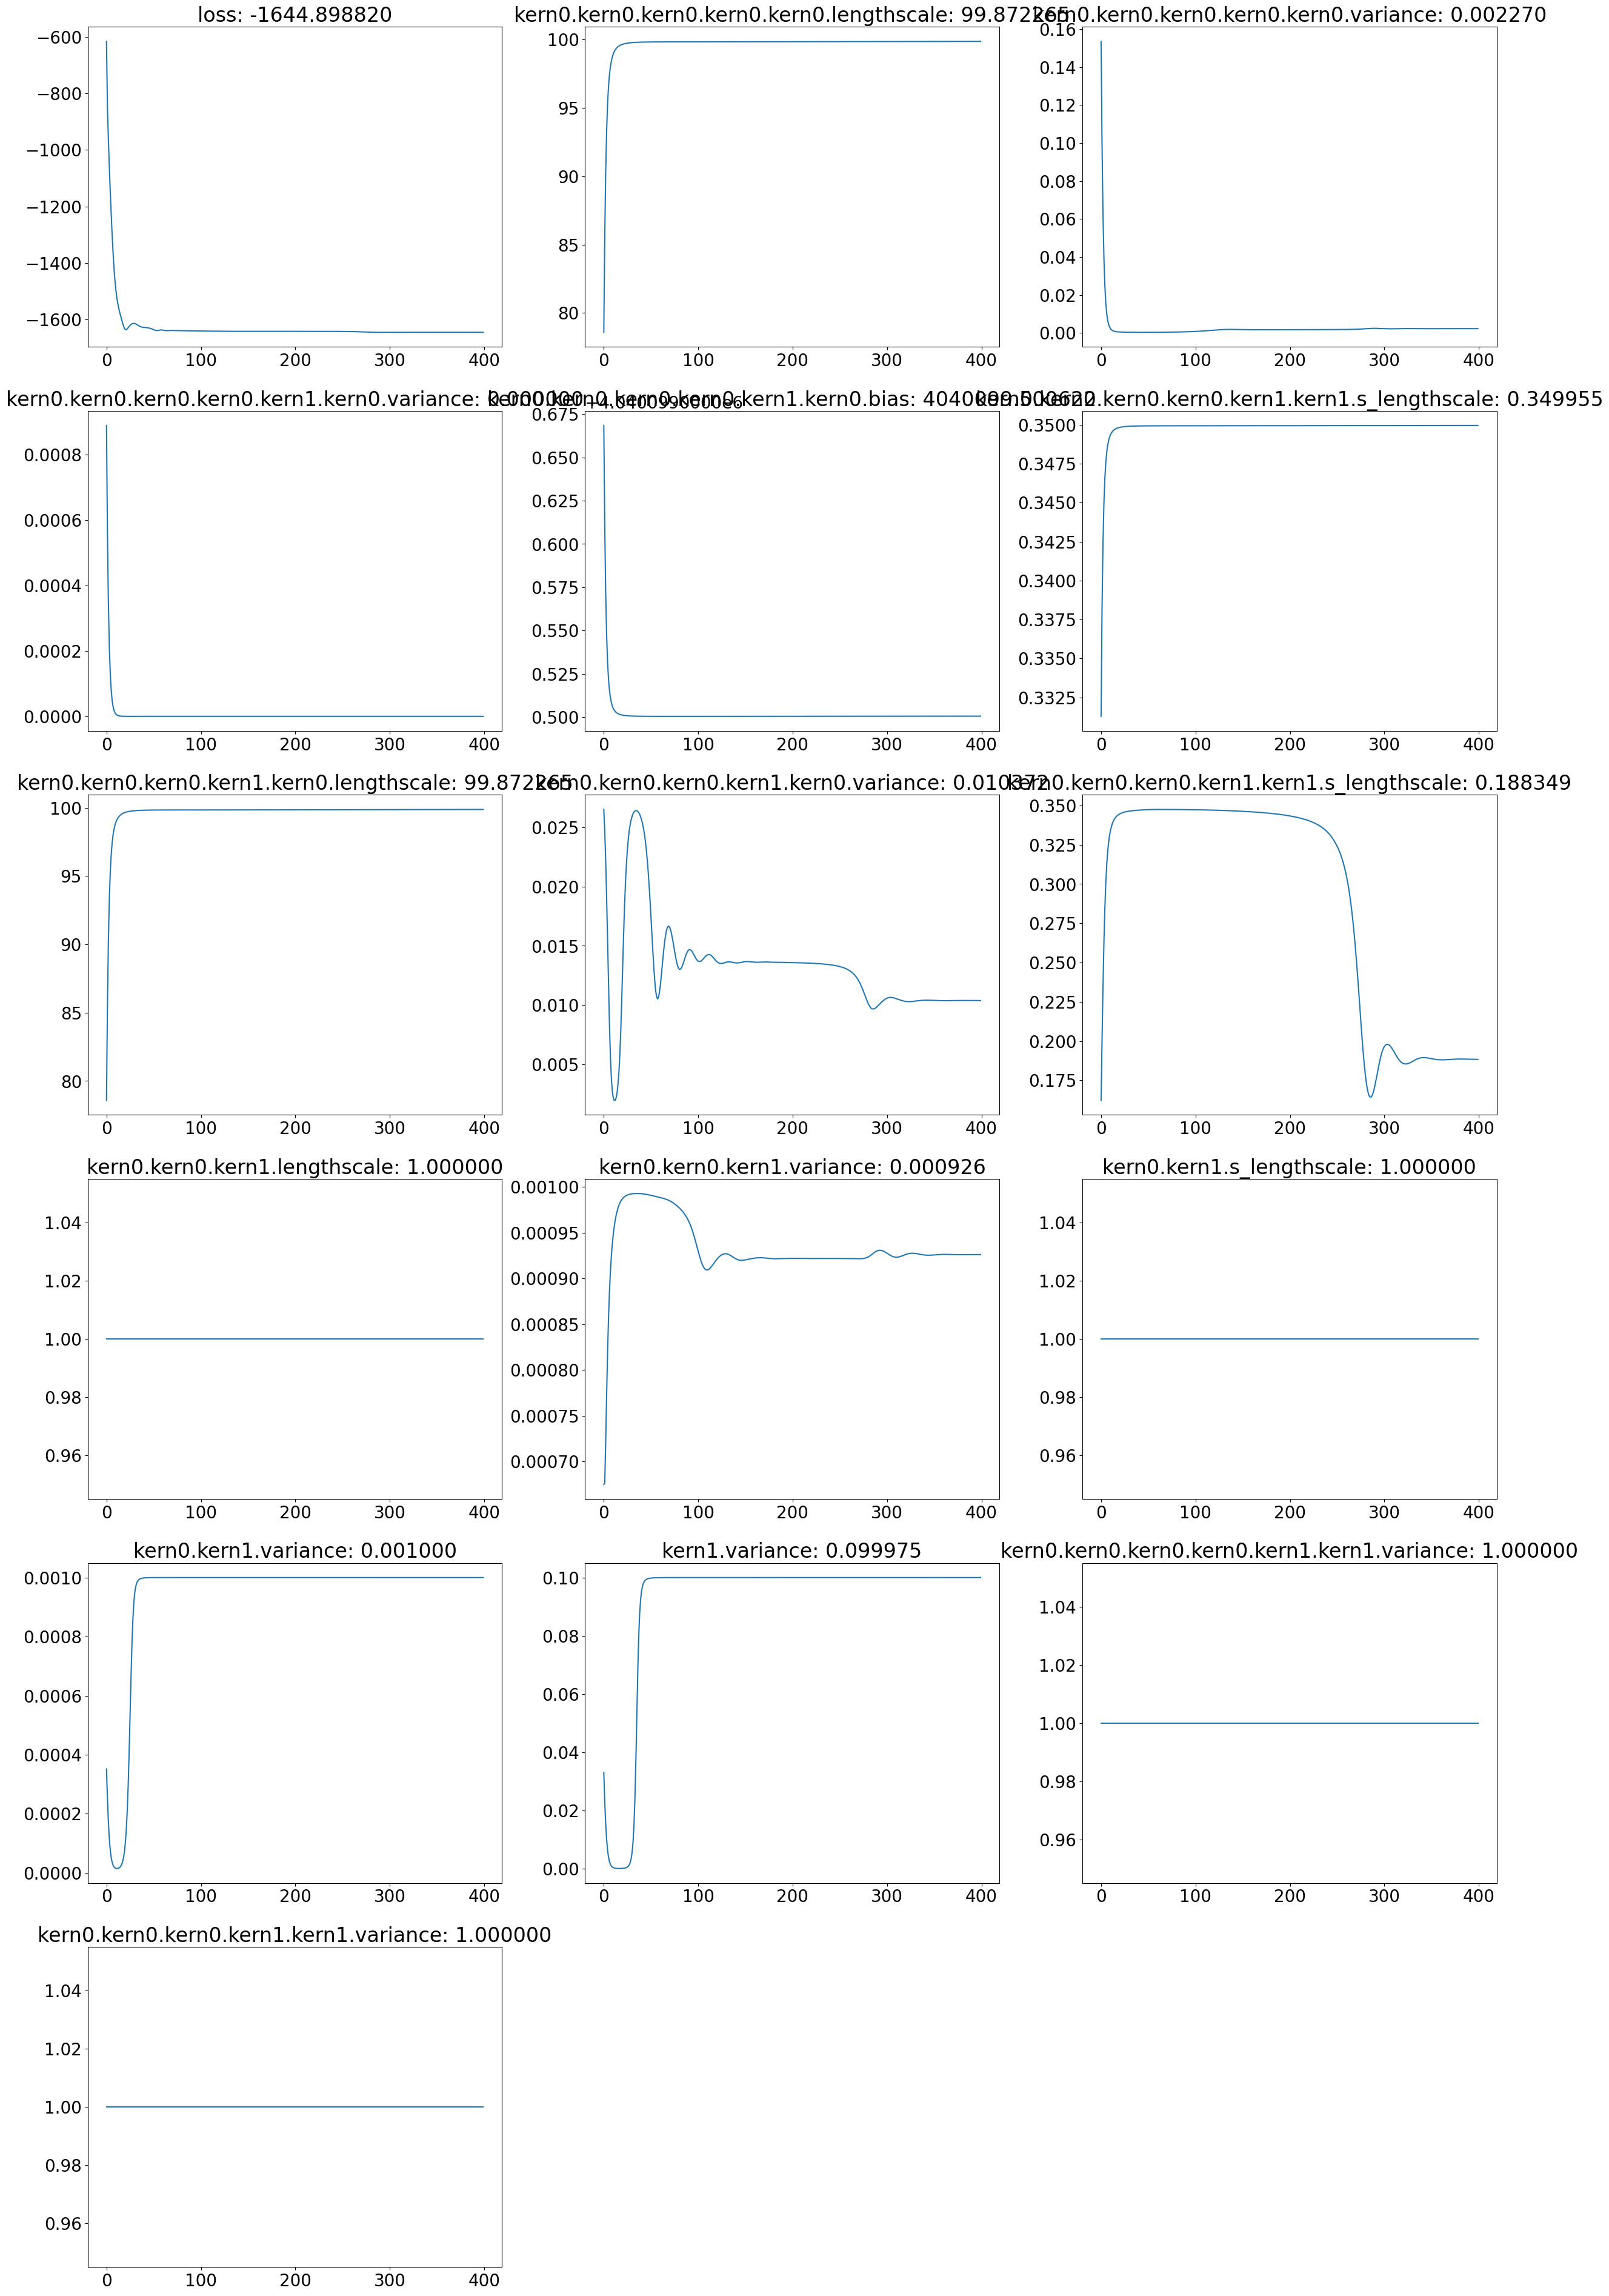

In [14]:
PSTHM.plot_track_list(track_list)

In [81]:
test_age = np.arange(-1000,2000,10)
pred_matrix = PSTHM.gen_pred_matrix(test_age,X_all[2,1],X_all[2,2])
y_mean, y_var = gpr(pred_matrix, full_cov=True)

#-----------------define the kernel to decompose-----------------
global_kernel =  gpr.kernel.kern0.kern0.kern0.kern0.kern0
regional_linear_kernel =gpr.kernel.kern0.kern0.kern0.kern0.kern1
regional_nl_kernel = gpr.kernel.kern0.kern0.kern0.kern1

#-----------------decompose the kernel-----------------
global_dep,reigonal_linear_dep,regional_nl_dep = PSTHM.decompose_kernels(gpr,pred_matrix,[global_kernel,regional_linear_kernel,regional_nl_kernel])
global_mean,global_var = global_dep
global_std = global_var.diag().sqrt()

regional_linear_mean,regional_linear_var = reigonal_linear_dep
regional_linear_std = regional_linear_var.diag().sqrt()

regional_nl_mean,regional_nl_var = regional_nl_dep
regional_nl_std = regional_nl_var.diag().sqrt()


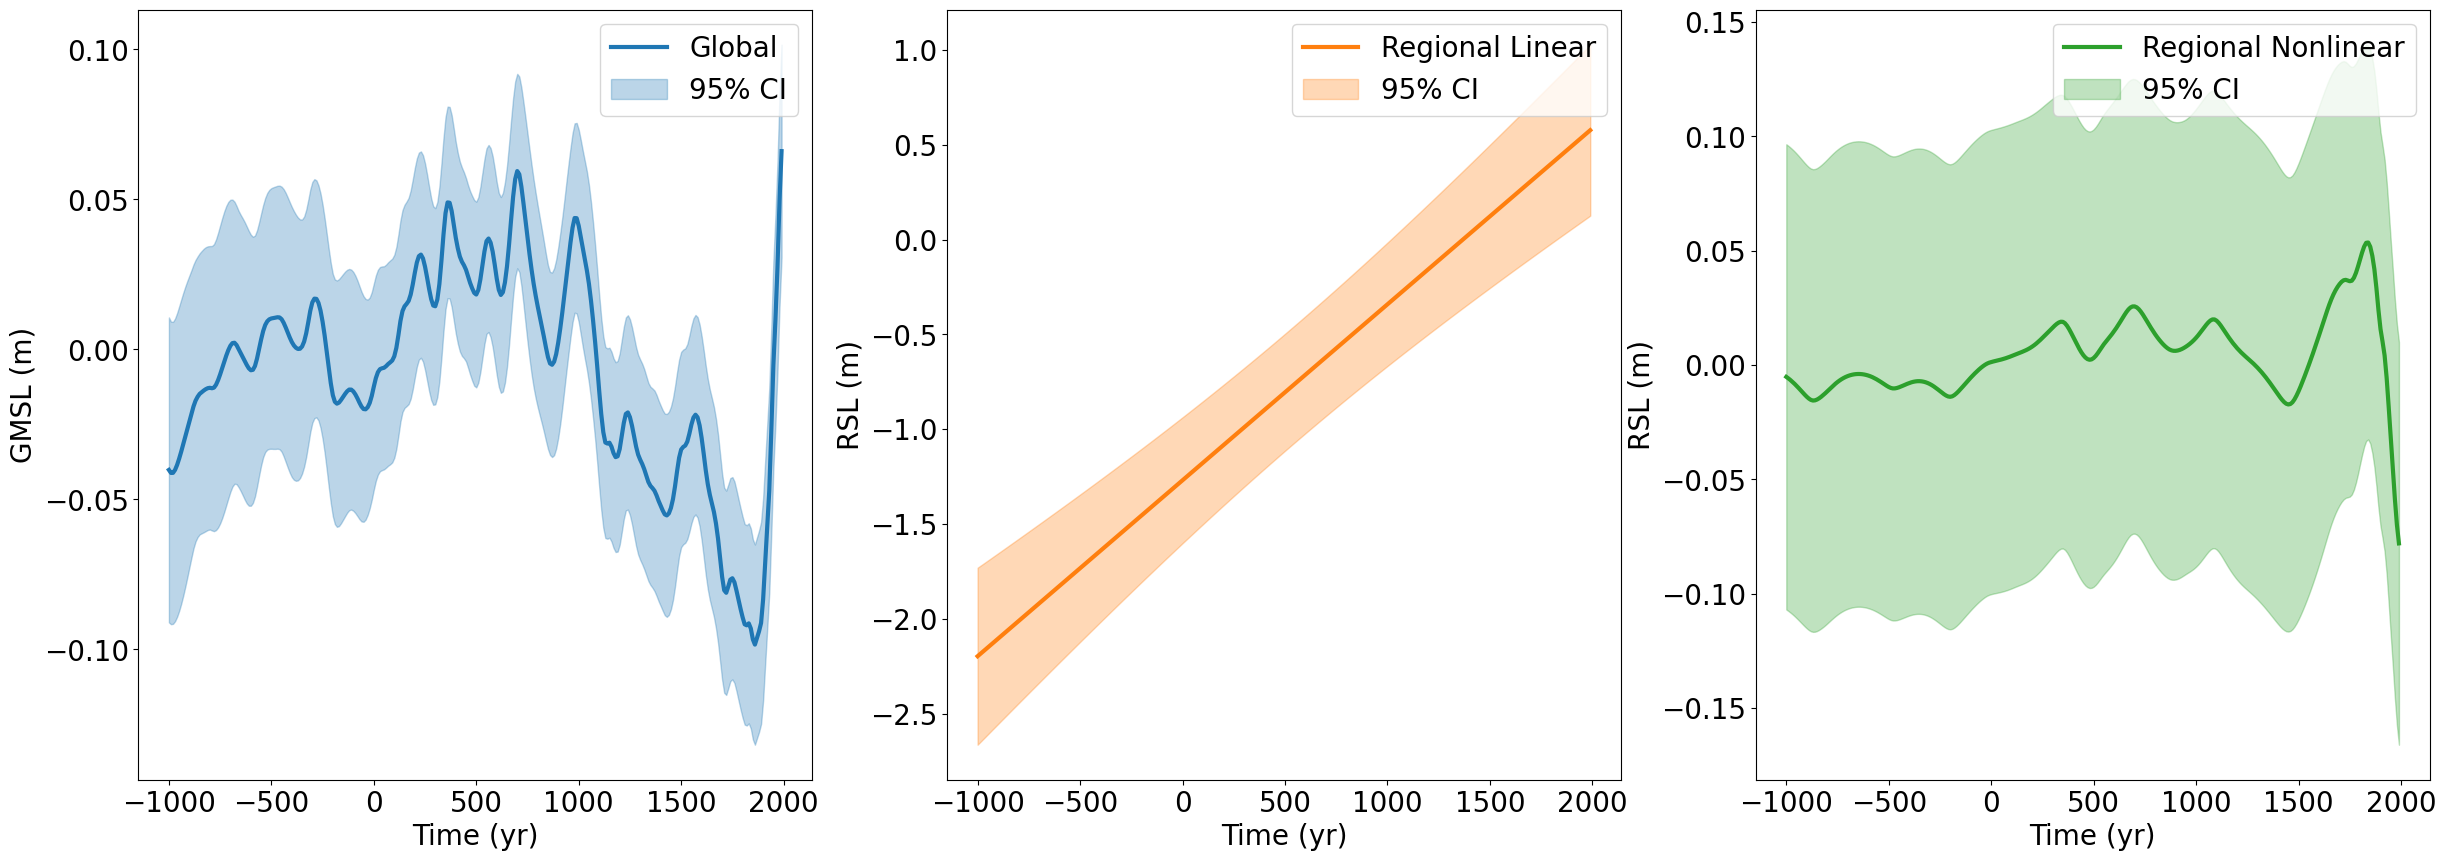

In [82]:
plt.figure(figsize=(40,10))
plt.subplot(141)
plt.plot(test_age,global_mean.detach().numpy(),'C0',linewidth=3,label='Global')
plt.fill_between(test_age,global_mean.detach().numpy()-1*global_std.detach().numpy(),global_mean.detach().numpy()+1*global_std.detach().numpy(),color='C0',alpha=0.3,label='95% CI')
plt.xlabel('Time (yr)')
plt.ylabel('GMSL (m)')
plt.legend()
plt.subplot(142)
plt.plot(test_age,regional_linear_mean.detach().numpy(),'C1',linewidth=3,label='Regional Linear')
plt.fill_between(test_age,regional_linear_mean.detach().numpy()-2*regional_linear_std.detach().numpy(),regional_linear_mean.detach().numpy()+2*regional_linear_std.detach().numpy(),color='C1',alpha=0.3,label='95% CI')
plt.xlabel('Time (yr)')
plt.ylabel('RSL (m)')
plt.legend()
plt.subplot(143)
plt.plot(test_age,regional_nl_mean.detach().numpy(),'C2',linewidth=3,label='Regional Nonlinear')
plt.fill_between(test_age,regional_nl_mean.detach().numpy()-2*regional_nl_std.detach().numpy(),regional_nl_mean.detach().numpy()+2*regional_nl_std.detach().numpy(),color='C2',alpha=0.3,label='95% CI')
plt.xlabel('Time (yr)')
plt.ylabel('RSL (m)')
plt.legend()

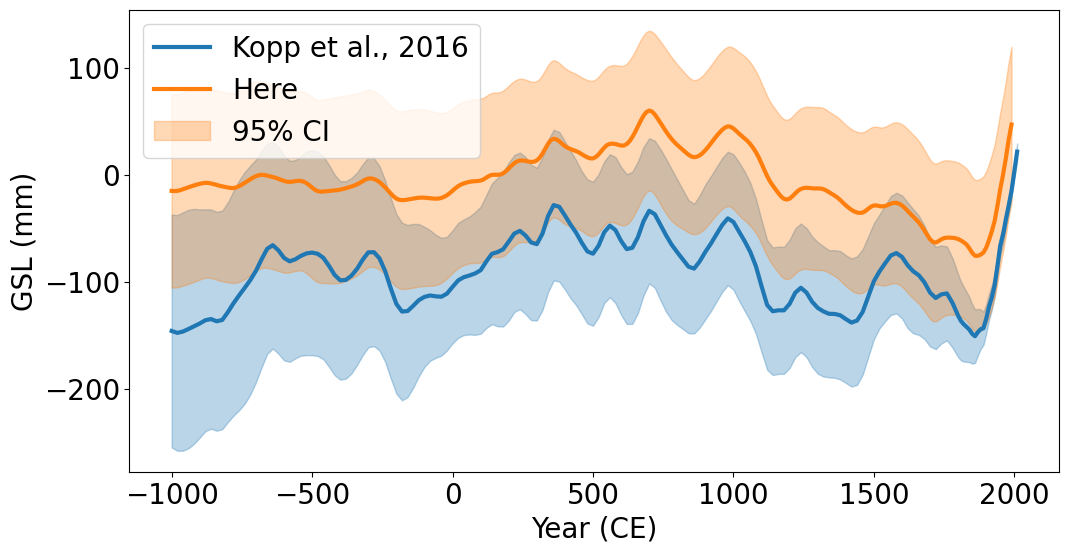

In [78]:
kopp2016 = pd.read_excel('IFILES/Kopp2016.xls',sheet_name=1,skiprows=2)
plt.plot(kopp2016['Year'], kopp2016['mm'],label='Kopp et al., 2016',lw=3)
# plt.fill_between(kopp2016['Year'],kopp2016['mm']+2*kopp2016['1s'],kopp2016['mm']-2*kopp2016['1s'],alpha=0.3,color='C0')

plt.plot(test_age,global_mean.detach().numpy()*1000,linewidth=3,label='Here')
# plt.fill_between(test_age,(global_mean.detach().numpy()-2*global_std.detach().numpy())*1000,(global_mean.detach().numpy()+2*global_std.detach().numpy())*1000,color='C1',alpha=0.3,label='95% CI')

plt.ylabel('GSL (mm)')
plt.xlabel('Year (CE)')
plt.legend()

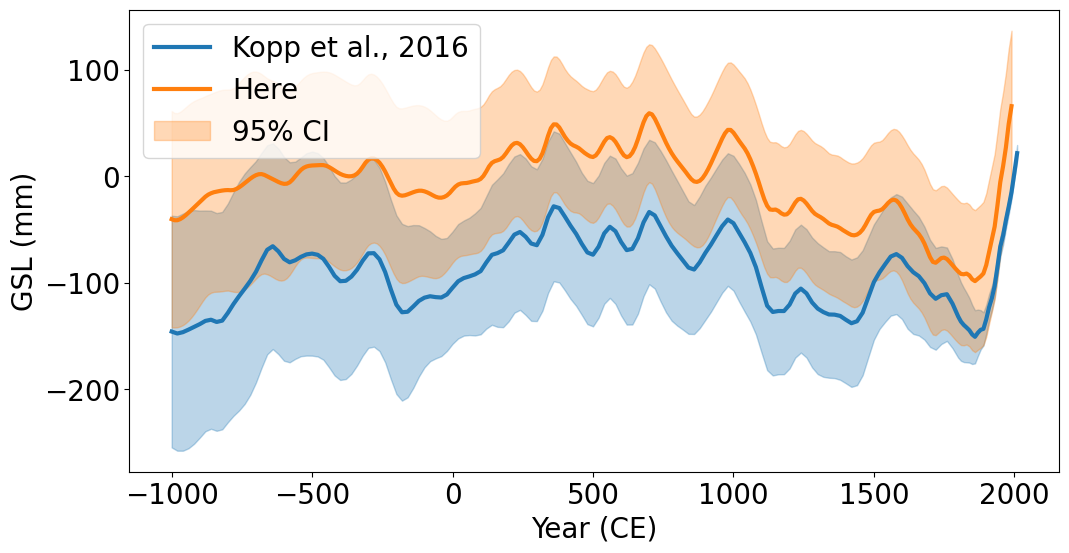

In [83]:
kopp2016 = pd.read_excel('IFILES/Kopp2016.xls',sheet_name=1,skiprows=2)
plt.plot(kopp2016['Year'], kopp2016['mm'],label='Kopp et al., 2016',lw=3)
plt.fill_between(kopp2016['Year'],kopp2016['mm']+2*kopp2016['1s'],kopp2016['mm']-2*kopp2016['1s'],alpha=0.3,color='C0')

plt.plot(test_age,global_mean.detach().numpy()*1000,linewidth=3,label='Here')
plt.fill_between(test_age,(global_mean.detach().numpy()-2*global_std.detach().numpy())*1000,(global_mean.detach().numpy()+2*global_std.detach().numpy())*1000,color='C1',alpha=0.3,label='95% CI')

plt.ylabel('GSL (mm)')
plt.xlabel('Year (CE)')
plt.legend()